# PyTorch CIFAR10

In [255]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [256]:
print(f"Size of train dataset: {len(train_dataset)}")
print(f"Size of test dataset: {len(test_dataset)}")
print(f"Shape of images: {train_dataset[0][0].shape}")
print(f"Classes: {train_dataset.classes}")

Size of train dataset: 50000
Size of test dataset: 10000
Shape of images: torch.Size([3, 32, 32])
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Visualize the data

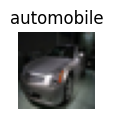

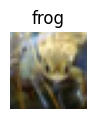

In [257]:
# Directly access the train_dataset and test_dataset without an iterator
train_image, train_label = train_dataset[np.random.randint(len(train_dataset))]
test_image, test_label = test_dataset[np.random.randint(len(test_dataset))]

mean = np.array([0.5, 0.5, 0.5]).reshape(3, 1, 1)
std = np.array([0.5, 0.5, 0.5]).reshape(3, 1, 1)

# Unnormalize
train_image = (std * train_image.numpy() + mean).transpose((1, 2, 0))
test_image = (std * test_image.numpy() + mean).transpose((1, 2, 0))

# Plot train image
plt.figure(figsize=(1, 1))
plt.imshow(train_image)
plt.axis('off')
plt.title(train_dataset.classes[train_label])
plt.show()

# Plot test image
plt.figure(figsize=(1, 1))
plt.imshow(test_image)
plt.axis('off')
plt.title(test_dataset.classes[test_label])
plt.show()


## Building `DataLoaders` classes to load data

In [258]:
from torch.utils.data import random_split

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

batch_size = 64

def create_loaders(batch_size):
    loaders = {
        'train': DataLoader(train_subset, batch_size=batch_size, shuffle=True),
        'val': DataLoader(val_subset, batch_size=batch_size, shuffle=False),
        'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    }
    return loaders

## Using the `dataloader`

torch.Size([64, 3, 32, 32])


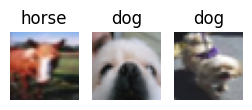

In [259]:
loaders = create_loaders(batch_size)

figure = plt.figure(figsize=(3, 3))
cols, rows = 3, 1

imgs, labels = next(iter(loaders['train']))
print(imgs.shape)  

# Define normalization parameters
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(imgs.shape[0], size=(1,)).item()
    img, label = imgs[sample_idx], labels[sample_idx].item()

    # Unnormalize directly here
    img = (std[:, None, None] * img.numpy() + mean[:, None, None]).transpose((1, 2, 0))

    figure.add_subplot(rows, cols, i)
    plt.title(loaders['train'].dataset.dataset.classes[label])
    plt.axis("off")
    plt.imshow(img)
    
plt.show()

## Model

In [260]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self, kernel_size=3, num_classes=10):
        super(CNN, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=kernel_size, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=kernel_size, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.out = nn.Linear(32*8*8, num_classes)
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

In [261]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [262]:
cnn = CNN().to(device)
print(cnn)

CNN(
  (block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2048, out_features=10, bias=True)
)


## Loss function

In [263]:
loss_func = nn.CrossEntropyLoss()
print(loss_func)

CrossEntropyLoss()


### In the following cell, I've been using a random search to search for the best parameters. Commented out due to the fact that this is a time consuming process

In [211]:
"""
import random

from torch import optim
num_epochs = 10
# Define the hyperparameters space
kernel_sizes = [3, 5]
batch_sizes = [64, 128, 256]
learning_rates = [0.001, 0.01]
optimizers_list = ['Adam', 'SGD']
momentums = [0.5, 0.9, 0.99]

best_val_accuracy = 0
best_params = {}

# Number of random combinations to try
num_combinations = 20  # Or any other number you deem appropriate

for _ in range(num_combinations):
    # Randomly sample hyperparameters
    kernel_size = random.choice(kernel_sizes)
    batch_size = random.choice(batch_sizes)
    lr = random.choice(learning_rates)
    opt = random.choice(optimizers_list)
    momentum = random.choice(momentums) if opt == 'SGD' else None

    # Set up your model and optimizer with the chosen hyperparameters
    loaders = create_loaders(batch_size)
    if opt == 'Adam':
        optimizer = optim.Adam(cnn.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(cnn.parameters(), lr=lr, momentum=momentum)
    
    # Train the model and get validation accuracy
    train_accuracies, val_accuracies = train_model(cnn, optimizer, num_epochs, loaders)

    # Check if the current combination is the best
    if max(val_accuracies) > best_val_accuracy:
        best_val_accuracy = max(val_accuracies)
        best_params = {
            'kernel_size': kernel_size,
            'batch_size': batch_size,
            'lr': lr,
            'optimizer': opt,
        }
        if momentum:
            best_params['momentum'] = momentum
print("Best parameters:", best_params)
"""

Total number of batches: 625
Starting epoch 1/10...
Epoch [1/10], Step [100/625], Loss: 1.1701, Training Accuracy: 53.89%
Epoch [1/10], Step [200/625], Loss: 1.0893, Training Accuracy: 53.67%
Epoch [1/10], Step [300/625], Loss: 1.0782, Training Accuracy: 53.86%
Epoch [1/10], Step [400/625], Loss: 1.2843, Training Accuracy: 54.41%
Epoch [1/10], Step [500/625], Loss: 1.1815, Training Accuracy: 54.71%
Epoch [1/10], Step [600/625], Loss: 1.2473, Training Accuracy: 55.00%
End of Epoch 1, Training Accuracy: 55.12%
End of Epoch 1, Validation Loss: 1.2305, Validation Accuracy: 56.46%
Starting epoch 2/10...
Epoch [2/10], Step [100/625], Loss: 1.2757, Training Accuracy: 58.36%
Epoch [2/10], Step [200/625], Loss: 1.2612, Training Accuracy: 58.55%
Epoch [2/10], Step [300/625], Loss: 1.0482, Training Accuracy: 58.36%
Epoch [2/10], Step [400/625], Loss: 1.2629, Training Accuracy: 58.12%
Epoch [2/10], Step [500/625], Loss: 0.9479, Training Accuracy: 58.24%
Epoch [2/10], Step [600/625], Loss: 0.9837, 

Epoch [5/10], Step [600/625], Loss: 0.7399, Training Accuracy: 72.16%
End of Epoch 5, Training Accuracy: 72.18%
End of Epoch 5, Validation Loss: 0.9503, Validation Accuracy: 67.35%
Starting epoch 6/10...
Epoch [6/10], Step [100/625], Loss: 0.8300, Training Accuracy: 71.56%
Epoch [6/10], Step [200/625], Loss: 0.6229, Training Accuracy: 71.97%
Epoch [6/10], Step [300/625], Loss: 0.9150, Training Accuracy: 72.14%
Epoch [6/10], Step [400/625], Loss: 0.8148, Training Accuracy: 72.25%
Epoch [6/10], Step [500/625], Loss: 0.9455, Training Accuracy: 72.18%
Epoch [6/10], Step [600/625], Loss: 1.0688, Training Accuracy: 72.18%
End of Epoch 6, Training Accuracy: 72.11%
End of Epoch 6, Validation Loss: 0.9476, Validation Accuracy: 67.16%
Starting epoch 7/10...
Epoch [7/10], Step [100/625], Loss: 0.8889, Training Accuracy: 72.31%
Epoch [7/10], Step [200/625], Loss: 0.7775, Training Accuracy: 72.46%
Epoch [7/10], Step [300/625], Loss: 0.7806, Training Accuracy: 72.15%
Epoch [7/10], Step [400/625], Lo

Epoch [4/10], Step [200/625], Loss: 0.4680, Training Accuracy: 78.52%
Epoch [4/10], Step [300/625], Loss: 0.4339, Training Accuracy: 78.29%
Epoch [4/10], Step [400/625], Loss: 0.5625, Training Accuracy: 78.18%
Epoch [4/10], Step [500/625], Loss: 0.5768, Training Accuracy: 77.82%
Epoch [4/10], Step [600/625], Loss: 0.5497, Training Accuracy: 77.78%
End of Epoch 4, Training Accuracy: 77.76%
End of Epoch 4, Validation Loss: 0.9582, Validation Accuracy: 68.21%
Early stopping!
Total number of batches: 625
Starting epoch 1/10...
Epoch [1/10], Step [100/625], Loss: 0.6094, Training Accuracy: 79.08%
Epoch [1/10], Step [200/625], Loss: 0.5930, Training Accuracy: 78.66%
Epoch [1/10], Step [300/625], Loss: 0.5209, Training Accuracy: 78.61%
Epoch [1/10], Step [400/625], Loss: 0.6743, Training Accuracy: 78.52%
Epoch [1/10], Step [500/625], Loss: 0.6437, Training Accuracy: 78.43%
Epoch [1/10], Step [600/625], Loss: 0.7271, Training Accuracy: 78.14%
End of Epoch 1, Training Accuracy: 78.13%
End of Ep

End of Epoch 2, Training Accuracy: 65.59%
End of Epoch 2, Validation Loss: 1.1764, Validation Accuracy: 60.41%
Starting epoch 3/10...
Epoch [3/10], Step [100/625], Loss: 1.0550, Training Accuracy: 69.06%
Epoch [3/10], Step [200/625], Loss: 0.9527, Training Accuracy: 68.05%
Epoch [3/10], Step [300/625], Loss: 0.6680, Training Accuracy: 67.20%
Epoch [3/10], Step [400/625], Loss: 0.8666, Training Accuracy: 66.51%
Epoch [3/10], Step [500/625], Loss: 1.1498, Training Accuracy: 66.26%
Epoch [3/10], Step [600/625], Loss: 0.9709, Training Accuracy: 65.80%
End of Epoch 3, Training Accuracy: 65.70%
End of Epoch 3, Validation Loss: 1.1863, Validation Accuracy: 60.01%
Starting epoch 4/10...
Epoch [4/10], Step [100/625], Loss: 0.7993, Training Accuracy: 70.67%
Epoch [4/10], Step [200/625], Loss: 0.8780, Training Accuracy: 68.79%
Epoch [4/10], Step [300/625], Loss: 1.2206, Training Accuracy: 67.89%
Epoch [4/10], Step [400/625], Loss: 1.0418, Training Accuracy: 67.38%
Epoch [4/10], Step [500/625], Lo

Epoch [1/10], Step [100/625], Loss: 0.4806, Training Accuracy: 81.95%
Epoch [1/10], Step [200/625], Loss: 0.4316, Training Accuracy: 81.54%
Epoch [1/10], Step [300/625], Loss: 0.5754, Training Accuracy: 81.17%
Epoch [1/10], Step [400/625], Loss: 0.4146, Training Accuracy: 81.10%
Epoch [1/10], Step [500/625], Loss: 0.6717, Training Accuracy: 80.96%
Epoch [1/10], Step [600/625], Loss: 0.5347, Training Accuracy: 80.79%
End of Epoch 1, Training Accuracy: 80.79%
End of Epoch 1, Validation Loss: 1.1127, Validation Accuracy: 66.62%
Starting epoch 2/10...
Epoch [2/10], Step [100/625], Loss: 0.5093, Training Accuracy: 81.97%
Epoch [2/10], Step [200/625], Loss: 0.5549, Training Accuracy: 81.98%
Epoch [2/10], Step [300/625], Loss: 0.3145, Training Accuracy: 81.76%
Epoch [2/10], Step [400/625], Loss: 0.4968, Training Accuracy: 81.64%
Epoch [2/10], Step [500/625], Loss: 0.7756, Training Accuracy: 81.69%
Epoch [2/10], Step [600/625], Loss: 0.5527, Training Accuracy: 81.56%
End of Epoch 2, Training A

End of Epoch 1, Validation Loss: 1.3327, Validation Accuracy: 65.10%
Starting epoch 2/10...
Epoch [2/10], Step [100/625], Loss: 0.3629, Training Accuracy: 86.02%
Epoch [2/10], Step [200/625], Loss: 0.3577, Training Accuracy: 85.82%
Epoch [2/10], Step [300/625], Loss: 0.4719, Training Accuracy: 85.78%
Epoch [2/10], Step [400/625], Loss: 0.3558, Training Accuracy: 85.95%
Epoch [2/10], Step [500/625], Loss: 0.4738, Training Accuracy: 85.94%
Epoch [2/10], Step [600/625], Loss: 0.5100, Training Accuracy: 85.90%
End of Epoch 2, Training Accuracy: 85.83%
End of Epoch 2, Validation Loss: 1.3318, Validation Accuracy: 65.24%
Starting epoch 3/10...
Epoch [3/10], Step [100/625], Loss: 0.5999, Training Accuracy: 86.69%
Epoch [3/10], Step [200/625], Loss: 0.3924, Training Accuracy: 86.62%
Epoch [3/10], Step [300/625], Loss: 0.4798, Training Accuracy: 86.38%
Epoch [3/10], Step [400/625], Loss: 0.3198, Training Accuracy: 86.18%
Epoch [3/10], Step [500/625], Loss: 0.4733, Training Accuracy: 86.11%
Epoc

Epoch [7/10], Step [500/625], Loss: 1.0372, Training Accuracy: 69.78%
Epoch [7/10], Step [600/625], Loss: 1.0506, Training Accuracy: 69.10%
End of Epoch 7, Training Accuracy: 69.00%
End of Epoch 7, Validation Loss: 1.2626, Validation Accuracy: 60.16%
Starting epoch 8/10...
Epoch [8/10], Step [100/625], Loss: 1.0031, Training Accuracy: 72.03%
Epoch [8/10], Step [200/625], Loss: 0.9212, Training Accuracy: 71.32%
Epoch [8/10], Step [300/625], Loss: 1.0483, Training Accuracy: 70.34%
Epoch [8/10], Step [400/625], Loss: 1.0362, Training Accuracy: 69.75%
Epoch [8/10], Step [500/625], Loss: 0.8324, Training Accuracy: 69.28%
Epoch [8/10], Step [600/625], Loss: 1.3665, Training Accuracy: 68.65%
End of Epoch 8, Training Accuracy: 68.53%
End of Epoch 8, Validation Loss: 1.3138, Validation Accuracy: 59.53%
Starting epoch 9/10...
Epoch [9/10], Step [100/625], Loss: 0.8083, Training Accuracy: 71.95%
Epoch [9/10], Step [200/625], Loss: 1.1936, Training Accuracy: 70.99%
Epoch [9/10], Step [300/625], Lo

Epoch [3/10], Step [200/625], Loss: 1.6874, Training Accuracy: 27.91%
Epoch [3/10], Step [300/625], Loss: 1.8731, Training Accuracy: 29.11%
Epoch [3/10], Step [400/625], Loss: 1.8585, Training Accuracy: 29.74%
Epoch [3/10], Step [500/625], Loss: 1.8231, Training Accuracy: 30.16%
Epoch [3/10], Step [600/625], Loss: 2.0568, Training Accuracy: 29.90%
End of Epoch 3, Training Accuracy: 29.89%
End of Epoch 3, Validation Loss: 1.8973, Validation Accuracy: 31.09%
Starting epoch 4/10...
Epoch [4/10], Step [100/625], Loss: 1.7245, Training Accuracy: 32.66%
Epoch [4/10], Step [200/625], Loss: 1.9691, Training Accuracy: 32.70%
Epoch [4/10], Step [300/625], Loss: 1.8259, Training Accuracy: 32.45%
Epoch [4/10], Step [400/625], Loss: 1.7429, Training Accuracy: 32.51%
Epoch [4/10], Step [500/625], Loss: 1.7706, Training Accuracy: 32.59%
Epoch [4/10], Step [600/625], Loss: 1.6962, Training Accuracy: 33.05%
End of Epoch 4, Training Accuracy: 33.11%
End of Epoch 4, Validation Loss: 1.7973, Validation Ac

In [264]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

## Train the model

In [265]:
num_epochs = 20
def train_model(model, optimizer, num_epochs, loaders):
    model.train()
    train_accuracies = []
    val_accuracies = []
    early_stopping_patience = 3
    early_stopping_counter = 0
    best_val_loss = float('inf')

    total_step = len(loaders['train'])
    print(f"Total number of batches: {total_step}")

    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch + 1}/{num_epochs}...")
        
        correct_train = 0
        total_train = 0
        # Training phase
        for i, (images, labels) in enumerate(loaders['train']):
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = loss_func(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted_train = torch.max(output.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            # Print every 100 steps
            if (i+1) % 100 == 0:
                train_accuracy = 100 * correct_train / ((i+1) * images.size(0))
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Training Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), train_accuracy))
        
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        print(f"End of Epoch {epoch+1}, Training Accuracy: {train_accuracy:.2f}%")

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(loaders['val']):
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = loss_func(output, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss /= len(loaders['val'])
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        print(f"End of Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping!")
            break
        
        model.train()  # Switch back to training mode for the next epoch

    return train_accuracies, val_accuracies

In [266]:
print("Training CNN...")
train_accuracies, val_accuracies = train_model(cnn, optimizer, num_epochs, loaders)

Training CNN...
Total number of batches: 625
Starting epoch 1/20...
Epoch [1/20], Step [100/625], Loss: 1.7958, Training Accuracy: 32.41%
Epoch [1/20], Step [200/625], Loss: 1.3531, Training Accuracy: 38.48%
Epoch [1/20], Step [300/625], Loss: 1.4357, Training Accuracy: 41.60%
Epoch [1/20], Step [400/625], Loss: 1.3993, Training Accuracy: 43.34%
Epoch [1/20], Step [500/625], Loss: 1.2617, Training Accuracy: 45.07%
Epoch [1/20], Step [600/625], Loss: 1.1515, Training Accuracy: 46.42%
End of Epoch 1, Training Accuracy: 46.81%
End of Epoch 1, Validation Loss: 1.2970, Validation Accuracy: 54.81%
Starting epoch 2/20...
Epoch [2/20], Step [100/625], Loss: 1.0965, Training Accuracy: 57.02%
Epoch [2/20], Step [200/625], Loss: 1.2558, Training Accuracy: 57.13%
Epoch [2/20], Step [300/625], Loss: 1.1459, Training Accuracy: 57.30%
Epoch [2/20], Step [400/625], Loss: 1.1868, Training Accuracy: 57.87%
Epoch [2/20], Step [500/625], Loss: 1.0641, Training Accuracy: 58.23%
Epoch [2/20], Step [600/625]

## Test the model on test dataset

In [267]:
def test_model(model, loaders):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loaders['test']:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on test images: {accuracy:.2f}%')
    return accuracy

In [268]:
print("Testing CNN...")
test_accuracy = test_model(cnn, loaders)

Testing CNN...
Accuracy of the model on test images: 68.30%


In [269]:
def test_model_per_class(model, loaders):
    model.eval()
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images, labels in loaders['test']:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print(f'Accuracy of {train_dataset.classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')

In [270]:
print("Testing model per class... ")
test_class_accuracy = test_model_per_class(cnn, loaders)

Testing model per class... 
Accuracy of airplane: 70.40%
Accuracy of automobile: 82.00%
Accuracy of bird: 57.10%
Accuracy of cat: 49.20%
Accuracy of deer: 69.00%
Accuracy of dog: 63.30%
Accuracy of frog: 73.60%
Accuracy of horse: 66.50%
Accuracy of ship: 79.70%
Accuracy of truck: 72.20%


## Print predictions

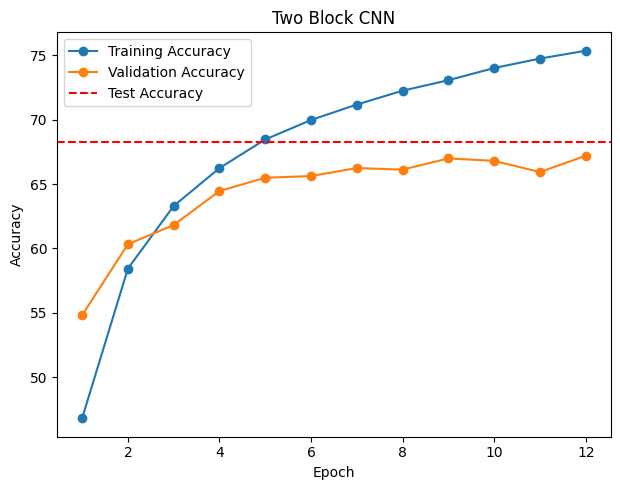

In [271]:
actual_num_epochs = len(train_accuracies)
epochs = list(range(1, actual_num_epochs + 1))

plt.figure(figsize=(12, 5))

# Two-block model accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, '-o', label='Training Accuracy')
plt.plot(epochs, val_accuracies, '-o', label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Two Block CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### Copying the CNN, but adding another layer for comparison

In [272]:
class CNN_v2(nn.Module):
    def __init__(self, kernel_size=3, num_classes=10):
        super(CNN_v2, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=kernel_size, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=kernel_size, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=kernel_size, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.out = nn.Linear(64*4*4, num_classes)
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

# Initialize and train the new model
cnn_v2 = CNN_v2().to(device)
optimizer_v2 = optim.SGD(cnn_v2.parameters(), lr=0.001, momentum=0.9)
print("Training CNN_v2...")
train_accuracies_v2, val_accuracies_v2 = train_model(cnn_v2, optimizer_v2, num_epochs, loaders)

Training CNN_v2...
Total number of batches: 625
Starting epoch 1/20...
Epoch [1/20], Step [100/625], Loss: 2.2948, Training Accuracy: 10.64%
Epoch [1/20], Step [200/625], Loss: 2.2924, Training Accuracy: 12.59%
Epoch [1/20], Step [300/625], Loss: 2.2536, Training Accuracy: 14.10%
Epoch [1/20], Step [400/625], Loss: 2.1737, Training Accuracy: 15.32%
Epoch [1/20], Step [500/625], Loss: 2.1173, Training Accuracy: 17.16%
Epoch [1/20], Step [600/625], Loss: 1.9507, Training Accuracy: 18.99%
End of Epoch 1, Training Accuracy: 19.40%
End of Epoch 1, Validation Loss: 1.9996, Validation Accuracy: 29.31%
Starting epoch 2/20...
Epoch [2/20], Step [100/625], Loss: 1.8257, Training Accuracy: 32.08%
Epoch [2/20], Step [200/625], Loss: 1.8706, Training Accuracy: 31.32%
Epoch [2/20], Step [300/625], Loss: 1.8346, Training Accuracy: 32.54%
Epoch [2/20], Step [400/625], Loss: 1.8037, Training Accuracy: 33.20%
Epoch [2/20], Step [500/625], Loss: 1.8520, Training Accuracy: 33.93%
Epoch [2/20], Step [600/6

Epoch [15/20], Step [600/625], Loss: 0.9239, Training Accuracy: 64.85%
End of Epoch 15, Training Accuracy: 65.01%
End of Epoch 15, Validation Loss: 1.0817, Validation Accuracy: 62.70%
Starting epoch 16/20...
Epoch [16/20], Step [100/625], Loss: 1.0088, Training Accuracy: 65.98%
Epoch [16/20], Step [200/625], Loss: 1.0556, Training Accuracy: 65.45%
Epoch [16/20], Step [300/625], Loss: 1.0652, Training Accuracy: 65.59%
Epoch [16/20], Step [400/625], Loss: 1.0981, Training Accuracy: 65.98%
Epoch [16/20], Step [500/625], Loss: 1.0300, Training Accuracy: 65.73%
Epoch [16/20], Step [600/625], Loss: 0.6601, Training Accuracy: 65.86%
End of Epoch 16, Training Accuracy: 65.90%
End of Epoch 16, Validation Loss: 1.0744, Validation Accuracy: 63.02%
Starting epoch 17/20...
Epoch [17/20], Step [100/625], Loss: 0.9058, Training Accuracy: 66.09%
Epoch [17/20], Step [200/625], Loss: 0.8948, Training Accuracy: 67.02%
Epoch [17/20], Step [300/625], Loss: 0.9373, Training Accuracy: 66.69%
Epoch [17/20], S

### Testing the models and visualizing predictions

In [273]:
print("Testing CNNv2...")
test_accuracy_v2 = test_model(cnn_v2, loaders)

Testing CNNv2...
Accuracy of the model on test images: 65.31%


In [274]:
print("Testing model per class... ")
test_class_accuracy_v2 = test_model_per_class(cnn_v2, loaders)

Testing model per class... 
Accuracy of airplane: 68.00%
Accuracy of automobile: 87.40%
Accuracy of bird: 59.70%
Accuracy of cat: 46.50%
Accuracy of deer: 50.50%
Accuracy of dog: 38.50%
Accuracy of frog: 79.40%
Accuracy of horse: 76.30%
Accuracy of ship: 85.00%
Accuracy of truck: 61.80%


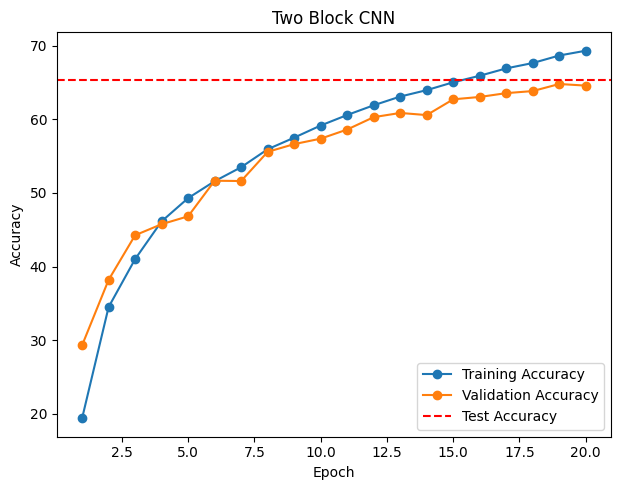

In [275]:
actual_num_epochs = len(train_accuracies_v2)
epochs = list(range(1, actual_num_epochs + 1))

plt.figure(figsize=(12, 5))

# Two-block model accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies_v2, '-o', label='Training Accuracy')
plt.plot(epochs, val_accuracies_v2, '-o', label='Validation Accuracy')
plt.axhline(y=test_accuracy_v2, color='r', linestyle='--', label='Test Accuracy')
plt.title('Two Block CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Just for fun: Printing the prediction of some of the photos using both models

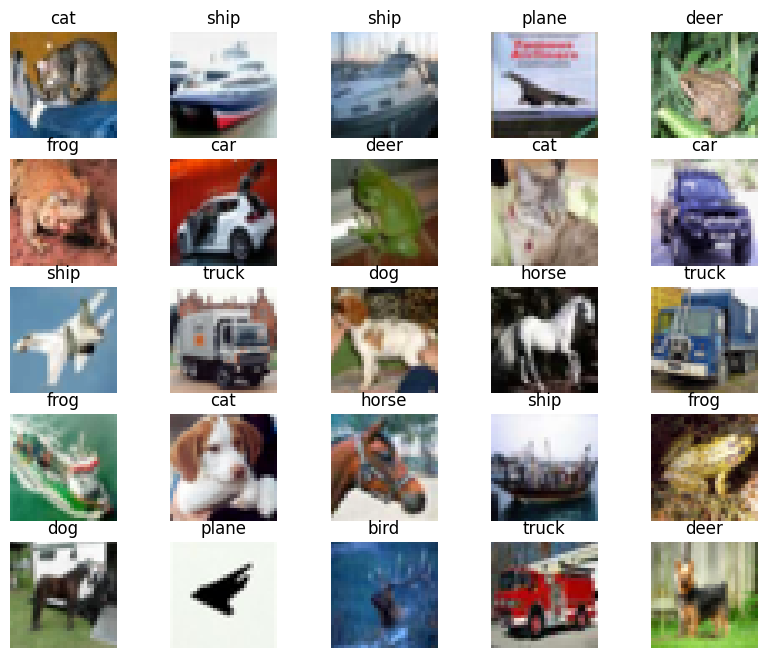

Prediction: 	 ['cat', 'ship', 'ship', 'plane', 'deer', 'frog', 'car', 'deer', 'cat', 'car', 'ship', 'truck', 'dog', 'horse', 'truck', 'frog', 'cat', 'horse', 'ship', 'frog', 'dog', 'plane', 'bird', 'truck', 'deer']
Actual: 	 ['cat', 'ship', 'ship', 'plane', 'frog', 'frog', 'car', 'frog', 'cat', 'car', 'plane', 'truck', 'dog', 'horse', 'truck', 'ship', 'dog', 'horse', 'ship', 'frog', 'horse', 'plane', 'deer', 'truck', 'dog']


In [276]:
# Get a batch of images and labels from the test set
imgs, lbls = next(iter(loaders['test']))
imgs, lbls = imgs.cuda(), lbls.cuda()
true_labels = lbls[:25].cpu().numpy()

# Using one_block_cnn for predictions
test_output = cnn(imgs[:25])
pred_labels = torch.max(test_output, 1)[1].data.cpu().numpy().squeeze()

# CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5

for i in range(1, cols * rows + 1):
    img = imgs[i-1].cpu().numpy().transpose(1, 2, 0)
    img = (img - img.min()) / (img.max() - img.min())  # normalize the image
    pred_label = classes[pred_labels[i-1].item()]
    figure.add_subplot(rows, cols, i)
    plt.title(pred_label)
    plt.axis("off")
    plt.imshow(img)
plt.show()

print(f'Prediction: \t {list(map(lambda x: classes[x], pred_labels))}')
print(f'Actual: \t {list(map(lambda x: classes[x], true_labels))}')

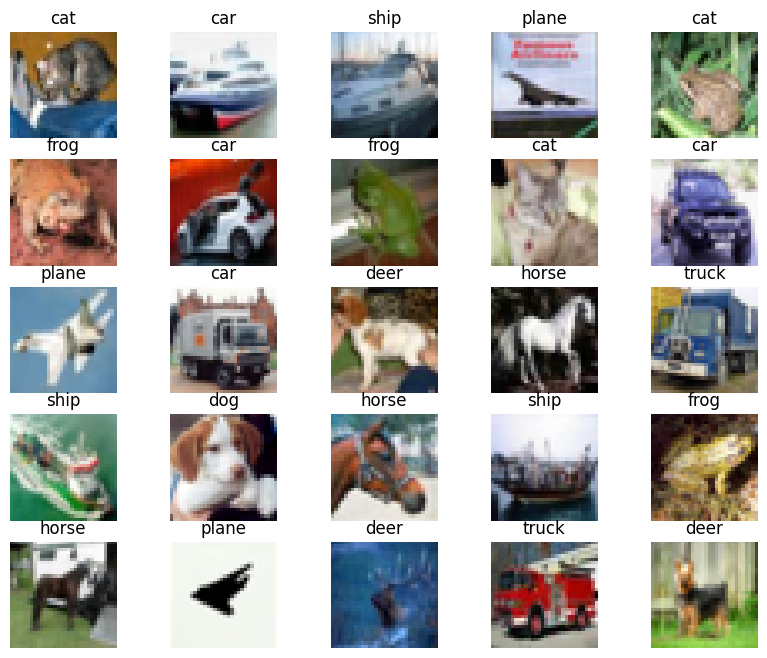

Prediction: 	 ['cat', 'car', 'ship', 'plane', 'cat', 'frog', 'car', 'frog', 'cat', 'car', 'plane', 'car', 'deer', 'horse', 'truck', 'ship', 'dog', 'horse', 'ship', 'frog', 'horse', 'plane', 'deer', 'truck', 'deer']
Actual: 	 ['cat', 'ship', 'ship', 'plane', 'frog', 'frog', 'car', 'frog', 'cat', 'car', 'plane', 'truck', 'dog', 'horse', 'truck', 'ship', 'dog', 'horse', 'ship', 'frog', 'horse', 'plane', 'deer', 'truck', 'dog']


In [277]:
# Get a batch of images and labels from the test set
imgs, lbls = next(iter(loaders['test']))
imgs, lbls = imgs.cuda(), lbls.cuda()
true_labels = lbls[:25].cpu().numpy()

# Using one_block_cnn for predictions
test_output = cnn_v2(imgs[:25])
pred_labels = torch.max(test_output, 1)[1].data.cpu().numpy().squeeze()

# CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5

for i in range(1, cols * rows + 1):
    img = imgs[i-1].cpu().numpy().transpose(1, 2, 0)
    img = (img - img.min()) / (img.max() - img.min())  # normalize the image
    pred_label = classes[pred_labels[i-1].item()]
    figure.add_subplot(rows, cols, i)
    plt.title(pred_label)
    plt.axis("off")
    plt.imshow(img)
plt.show()

print(f'Prediction: \t {list(map(lambda x: classes[x], pred_labels))}')
print(f'Actual: \t {list(map(lambda x: classes[x], true_labels))}')